# Buck synchronous rectifier design
this is a design of inductor buck synchronous rectifier, the design is based on https://www.ti.com/lit/ds/symlink/pth08t250w.pdf?ts=1735049340731

In [6]:
import numpy as np

vin = [4.5, 14]
vin = np.linspace(4.5, 14, 2, endpoint=True)
vo = [0.7, 3.6]
vo = np.linspace(0.7, 3.6, 2, endpoint=True)
io = 50

# create dataframes with combinations of vin, vo, and io as columns

import pandas as pd
import itertools

df = pd.DataFrame(list(itertools.product(vin, vo, [io])), columns=['vin', 'vo', 'io'])
#add row 50% duty cycle as worst case for inductor current ripple

# calculate output section
df['po'] = df['vo'] * df['io']

# calculate loss section
Pidle = 0.01 * df['po'].max()
Ploss_cond_max = 0.05*df['po'].max()
Ro_max = Ploss_cond_max / df['io'].max()**2
df['ploss'] = Pidle + Ro_max * df['io']**2

# calculate input section
df['pin'] = df['po'] + df['ploss']
df['iin'] = df['po'] / df['vin']

# calculate efficiency
df['eff'] = df['po'] / df['pin']
df['duty'] = df['vo'] / df['vin'] # supposed to be CCM

# constraints
fsw = 100e3
df['ioripple'] = 0.2 * df['io']
df['Lmin'] = (df['vin'] - df['vo']) * df['duty'] / df['ioripple'] / fsw

# print results
df.sort_values(by='po', ascending=False, inplace=True)
df

,vin,vo,io,po,ploss,pin,iin,eff,duty,ioripple,Lmin
1,4.5,3.6,50,180.0,10.8,190.8,40.000000,0.943396,0.800000,10.0,7.200000e-07
3,14.0,3.6,50,180.0,10.8,190.8,12.857143,0.943396,0.257143,10.0,2.674286e-06
0,4.5,0.7,50,35.0,10.8,45.8,7.777778,0.764192,0.155556,10.0,5.911111e-07
2,14.0,0.7,50,35.0,10.8,45.8,2.500000,0.764192,0.050000,10.0,6.650000e-07


<Axes: xlabel='po'>

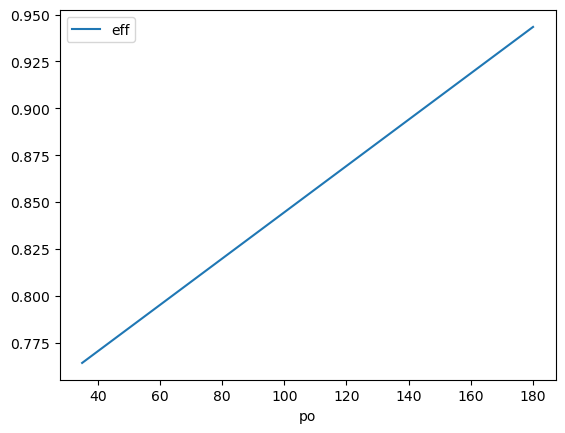

In [7]:
# plot results
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
df.plot(x='po', y='eff', ax=ax)

In [8]:
# define inductance range
Lo_range = [df['Lmin'].min(), df['Lmin'].max()]
print(Lo_range)



[5.911111111111111e-07, 2.6742857142857144e-06]


In [9]:
import PyMKF
import json
import pprint

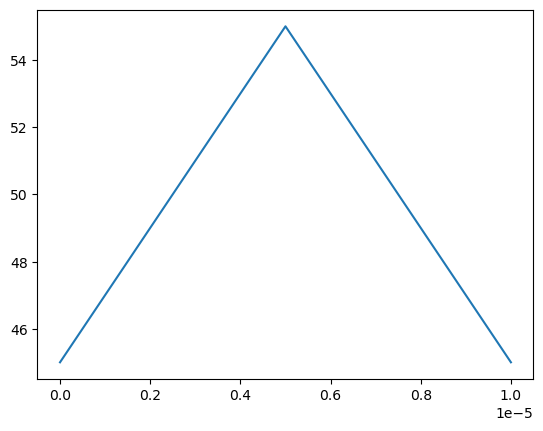

In [10]:
processed_waveform = {
    "offset": 50,
    "label": "Triangular",
    "peakToPeak": 50*0.2,
}

waveform = PyMKF.create_waveform(processed_waveform, fsw)

fig, ax = plt.subplots()
ax.plot(waveform['time'], waveform['data'])
plt.show()


In [11]:
from collections import defaultdict

# Function to create a nested defaultdict
def nested_dict():
    return defaultdict(nested_dict)


In [12]:
# Create the dynamic dictionary
inputs = nested_dict()
inputs["operatingPoints"][0]["excitationsPerWinding"][0] = {}
inputs["operatingPoints"][0]["excitationsPerWinding"][0]["frequency"] = fsw
inputs["operatingPoints"][0]["excitationsPerWinding"][0]["current"] = {}
inputs["operatingPoints"][0]["excitationsPerWinding"][0]["current"]["waveform"] = waveform
inputs["operatingPoints"][0]["excitationsPerWinding"][0]["voltage"] = PyMKF.calculate_induced_voltage(inputs["operatingPoints"][0]["excitationsPerWinding"][0], np.min(Lo_range))
inputs["operatingPoints"][0]["excitationsPerWinding"][1] = PyMKF.calculate_reflected_secondary(inputs["operatingPoints"][0]["excitationsPerWinding"][0], fsw)

In [17]:
import json

mas_filename = "./custom_magnetic_2.json"

with open(mas_filename) as file:
    mas = json.load(file)

In [25]:
inputs =mas['inputs']

In [26]:
magnetic = mas["magnetic"]
pprint.pprint(magnetic["core"])

{'distributorsInfo': [{'cost': 0.7,
                       'country': 'USA',
                       'distributedArea': 'International',
                       'email': None,
                       'link': 'https://www.digikey.com/en/products/detail/epcos-tdk-electronics/B66307G0500X187/3914670',
                       'name': 'Digi-Key',
                       'phone': None,
                       'quantity': 6354,
                       'reference': '495-76703-ND',
                       'updatedAt': '16/04/2024'}],
 'functionalDescription': {'coating': None,
                           'gapping': [{'area': 8.4e-05,
                                        'coordinates': [0, 0.00025, 0],
                                        'distanceClosestNormalSurface': 0.005401,
                                        'distanceClosestParallelSurface': 0.0035249999999999995,
                                        'length': 0.0005,
                                        'sectionDimensions': [0.004

In [29]:
mas_result = PyMKF.simulate(inputs, magnetic, {})
mas_result

Simulating magnetizing_inductance
Simulating core_losses
Simulating winding_losses
Simulating leakage inductance
Simulation complete
Simulating magnetizing_inductance
Simulating core_losses
Simulating winding_losses
Simulating leakage inductance
Simulation complete


{'inputs': {'designRequirements': {'insulation': None,
   'isolationSides': ['primary'],
   'leakageInductance': None,
   'magnetizingInductance': {'excludeMaximum': None,
    'excludeMinimum': None,
    'maximum': 0.00019999999999999998,
    'minimum': 6e-07,
    'nominal': 1e-06},
   'market': None,
   'maximumDimensions': None,
   'maximumWeight': None,
   'name': 'test_buck',
   'operatingTemperature': {'excludeMaximum': None,
    'excludeMinimum': None,
    'maximum': 85.0,
    'minimum': None,
    'nominal': None},
   'strayCapacitance': None,
   'terminalType': None,
   'topology': 'Buck Converter',
   'turnsRatios': [],
   'wiringTechnology': None},
  'operatingPoints': [{'conditions': {'ambientRelativeHumidity': None,
     'ambientTemperature': 42.0,
     'cooling': None,
     'name': None},
    'excitationsPerWinding': [{'current': {'harmonics': {'amplitudes': [49.99915508198884,
         10.144185455067742,
         3.4729177689172013,
         0.9862415818750925,
         0

In [30]:
pprint.pprint(f'Core losses at {fsw}: {mas_result["outputs"][0]["coreLosses"]["coreLosses"]}')
pprint.pprint(f'Winding losses at {fsw}: {mas_result["outputs"][0]["windingLosses"]["windingLosses"]}')

'Core losses at 100000.0: 0.2613095939550127'
'Winding losses at 100000.0: 10.342524625963108'
